In [1]:
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import os 
import wave
import time
from d2l import mxnet as d2l
import mxnet as mx
from mxnet import nd, initializer as init, optimizer,gluon,autograd
from mxnet.gluon import nn,data as gdata,loss as gloss,Trainer
from IPython import display
import random
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import pandas
from pandas import Series,DataFrame

# 音频的可视化 (visualization of audio data)

33953 152792
(169769,)


/home/hzx/anaconda3/envs/gluon/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


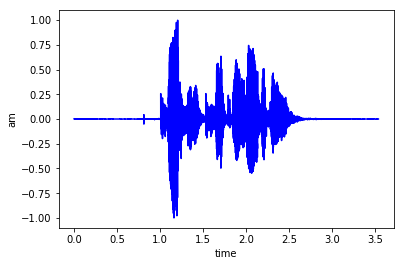

In [2]:
path='/home/hzx/.mxnet/datasets/speech emotion/Actor_01/03-01-02-01-01-01-01.wav'
f = wave.open(path,'rb')
params = f.getparams()
#nchannels,samplewidth,framerate,nframes
nchannels,samplewidth,framerate,nframes = params[:4]
voiceStrData = f.readframes(nframes)
waveData = np.fromstring(voiceStrData, dtype = np.short)
#normalize waveData
waveData = waveData * 1.0/max(abs(waveData))
print(int(nframes*0.2),int(nframes*0.9))
waveData = np.reshape(waveData,[nframes,nchannels])
begin_point = 0
end_point = 1
waveData = waveData[int(nframes*begin_point):int(nframes*end_point),].T
f.close()
times = np.arange(int(nframes*begin_point), int(nframes*end_point))*(1.0/framerate*(end_point-begin_point))
print(times.shape)
plt.plot(times,waveData[0,:],c='b')
plt.xlabel('time')
plt.ylabel('am')
plt.show()

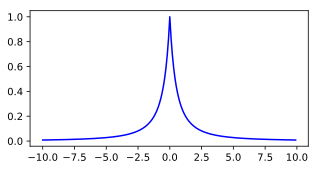

In [3]:
data = nd.arange(-10,10,0.1)
data.attach_grad()
with autograd.record():
    output = data/(abs(data)+1)
output.backward()
d2l.set_figsize(figsize= (5,2.5))
d2l.plt.plot(data.asnumpy(),data.grad.asnumpy(),c='b')
d2l.plt.show()

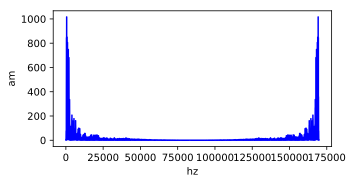

In [4]:
fftdata = np.fft.fft(waveData[0,:])
fftdata = abs(fftdata)
hz_axis = np.arange(0,len(fftdata))
plt.figure()
plt.plot(hz_axis, fftdata, c='b')
plt.xlabel('hz')
plt.ylabel('am')
plt.show()

In [5]:
#帧长20~30ms
framelength = 0.025 
#每帧点数 N = t*fs,通常情况下值为256或512,要与NFFT相等
#而NFFT最好取2的整数次方,即framesize最好取的整数次方
framesize = framelength* framerate
nfftdict = {}
lists = {32,64,128,525,1024}
for i in lists:
    nfftdict[i] = abs(framesize-i)
framesize = sorted(nfftdict.items(),key = lambda x:x[1])[0][0]
print(framesize)

1024


In [6]:
print(waveData.shape)

(1, 169769)


341


/home/hzx/anaconda3/envs/gluon/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Text(0.5,1,'Spectrogram')

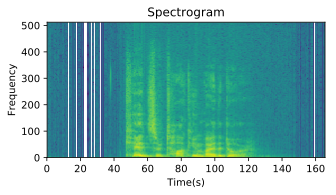

In [7]:
NFFT = framesize 
overlapSize = 1.0/3 * framesize
overlapSize = int(round(overlapSize)) #取整
print(overlapSize)
spectrum, freqs, ts, fig = plt.specgram(waveData[0],NFFT = NFFT, 
                                        Fs = framesize, window = np.hamming(M = framesize),
                                        noverlap = overlapSize, mode = 'default', 
                                        scale_by_freq = True, sides = 'default',scale = 'dB',
                                        xextent = None)
plt.ylabel('Frequency')
plt.xlabel('Time(s)')
plt.title('Spectrogram')

Text(0.5,1.05,'MFCC')

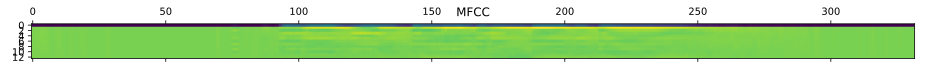

In [8]:
y,sr = librosa.load(path,sr=None)
y,sr = librosa.load(path,sr=None)

mfcc_data = librosa.feature.mfcc( y,sr,n_mfcc=13)
plt.matshow(mfcc_data)
plt.title('MFCC')

/home/hzx/anaconda3/envs/gluon/lib/python3.6/site-packages/ipykernel_launcher.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  



MFCC:
窗口数 = 353
每个特征的长度 = 13

Filter bank:
窗口数 = 353
每个特征的长度 = 26


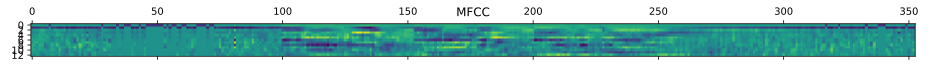

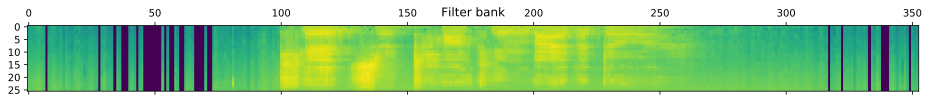

In [11]:
# 读取输入音频文件
sampling_freq, audio = wavfile.read(path)
# 提取MFCC和滤波器组特征
mfcc_features = mfcc(audio, sampling_freq)
filterbank_features = logfbank(audio, sampling_freq)
print('\nMFCC:\n窗口数 =', mfcc_features.shape[0])
print('每个特征的长度 =', mfcc_features.shape[1])
print('\nFilter bank:\n窗口数 =', filterbank_features.shape[0])
print('每个特征的长度 =', filterbank_features.shape[1])
# 画出特征图，将MFCC可视化。转置矩阵，使得时域是水平的
mfcc_features = mfcc_features.T
plt.matshow(mfcc_features)
plt.title('MFCC')
# 将滤波器组特征可视化。转置矩阵，使得时域是水平的
filterbank_features = filterbank_features.T
plt.matshow(filterbank_features)
plt.title('Filter bank')
plt.show()

In [12]:
width = mfcc_features.shape[1]
mfcc_features = mfcc_features.T[int(width*0.3):int(width*0.7),]

Text(0.5,1.05,'MFCC')

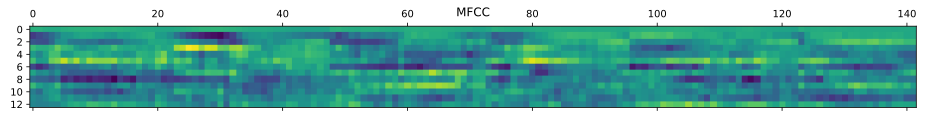

In [13]:
plt.matshow(mfcc_features.T)
plt.title('MFCC')

# 预处理数据 (preprocessing data)

In [14]:
def get_all_data(data_type,type2):
    neutral = []
    calm = []
    happy = []
    sad = []
    angry = []
    fearful = []
    disgust = []
    suprised = []
    path=r'/home/hzx/.mxnet/datasets/speech emotion/Actor_01/03-01-02-01-01-01-01.wav'
    path=r'/home/hzx/.mxnet/datasets/speech emotion'
    actor_list = os.listdir(path)
    for actor in actor_list:
        audio_files = ''
        if data_type == "train" and len(actor)<10:
            audio_files = os.listdir('/home/hzx/.mxnet/datasets/speech emotion/%s'%actor)
            for file in audio_files:
                if file[7] == '1' :
                    neutral.append((actor,file))
                if file[7] =='2':
                    if type2 and file[10]==type2:
                        calm.append((actor,file))
                    else:
                        calm.append((actor,file))
                if file[7] == '3':
                    if type2 and file[10]==type2:
                        happy.append((actor,file))
                    else:
                        happy.append((actor,file))
                if file[7] == '4':
                    if type2 and file[10]==type2:
                        sad.append((actor,file))
                    else:
                        sad.append((actor,file))
                if file[7] == '5':
                    if type2 and file[10]==type2:
                        angry.append((actor,file))
                    else:
                        angry.append((actor,file))
                if file[7] == '6':
                    if type2 and file[10]==type2:
                        fearful.append((actor,file))
                    else:
                        fearful.append((actor,file))
                if file[7] == '7':
                    if type2 and file[10]==type2:
                        disgust.append((actor,file))
                    else:
                        disgust.append((actor,file))
                if file[7] == '8':
                    if type2 and file[10]==type2:
                        suprised.append((actor,file))
                    else:
                        suprised.append((actor,file))
        elif data_type == "test" and len(actor)>10:
            test_actor_list = os.listdir('/home/hzx/.mxnet/datasets/speech emotion/%s'%actor)
            for test_actor in test_actor_list:
                audio_files = os.listdir('/home/hzx/.mxnet/datasets/speech emotion/%s/%s'%(actor,test_actor))
                for file in audio_files:
                    if file[7] == '1':
                        neutral.append((actor,test_actor, file))
                    if file[7] =='2':
                        if type2 and file[10]==type2:
                            calm.append((actor,test_actor, file))
                        else:
                            calm.append((actor,test_actor, file))
                    if file[7] == '3':
                        if type2 and file[10]==type2:
                            happy.append((actor,test_actor, file))
                        else:
                            happy.append((actor,test_actor, file))
                    if file[7] == '4':
                        if type2 and file[10]==type2:
                            sad.append((actor,test_actor, file))
                        else:
                            sad.append((actor,test_actor, file))
                    if file[7] == '5':
                        if type2 and file[10]==type2:
                            angry.append((actor,test_actor, file))
                        else:
                            angry.append((actor,test_actor, file))
                    if file[7] == '6':
                        if type2 and file[10]==type2:
                            fearful.append((actor,test_actor, file))
                        else:
                            fearful.append((actor,test_actor, file))
                    if file[7] == '7':
                        if type2 and file[10]==type2:
                            disgust.append((actor,test_actor, file))
                        else:
                            disgust.append((actor,test_actor, file))
                    if file[7] == '8':
                        if type2 and file[10]==type2:
                            suprised.append((actor,test_actor, file))
                        else:
                            suprised.append((actor,test_actor, file))
    return (neutral, calm, happy, sad, angry, fearful, disgust, suprised)

In [15]:
all_training_data = get_all_data("train",'1')

In [16]:
data_length = 0
for i in all_training_data:
    data_length+=len(i);
data_length

1440

# 创建dataset，预处理音频数据 (set up dataset and preprocessing audio data)

In [18]:
class speech_emotion_datasets(gdata.Dataset):
    def __init__ (self,data_type,begin_point,normalizedLen, ratio = 5/6, samplerate= 48000, framelength = 0.025):
        self.data_type = data_type
        self.ratio = ratio 
        self.begin_point = begin_point
        self.normalizedLen = normalizedLen
        self.samplerate = samplerate
        self.framelength = framelength
        self.N_FFT = self.get_nearest_len(framelength,samplerate)
        self.features,self.labels = self.get_features(data_type,self.begin_point, self.normalizedLen)
    def __getitem__(self,idx):
        return (self.features[idx],self.labels[idx])
    def normalize(self,data):
        mean = data.mean()
        std = data.std()
        return (data-mean)/std
    def __len__(self):
        return len(self.features)
    def normalizeVoiceLen(self,y,normalizedLen,start_point):
        nframes=y.shape[0]
        start_len = int(nframes*start_point)
        if len(y.shape)>1:
            y = np.reshape(y.mean(axis=1),[nframes,1]).T
        else:
            y = np.reshape(y,[nframes,1]).T
        #裁剪音频长度为2s,32000数据点
        if(start_len+normalizedLen> nframes):
            res=start_len+normalizedLen-nframes
            res_data=np.zeros([1,res],dtype=np.float32)
            y = y[:,start_len:]
            y=np.c_[y,res_data]
        else:
            y=y[:,start_len:(start_len+normalizedLen)]
        return y[0]
    def get_nearest_len(self,framelength ,samplerate):
        frame_size = framelength*sr
        nfft_dic = {}
        lists = [32,64,128,512,1024]
        for i in lists:
            nfft_dic[i] = abs(frame_size-i)
        nearest_len = sorted(nfft_dic.items(),key = lambda x:x[1])[0][0]
        return nearest_len
    def get_features(self, data_type, start_point,normalizedLen):
        features_1 = get_all_data('train','1')
        features_2 = get_all_data('test','1')
        output = []
        for data in features_1:
            for file_path in data:
                output.append(file_path)
        for data in features_2:
            for file_path in data:
                output.append(file_path)
        features = []
        labels = []
        data = []
        for file_name in output:
            if (len(file_name) == 2):
                sampling_freq, audio = wavfile.read('/home/hzx/.mxnet/datasets/speech emotion/%s/%s'%(file_name[0],file_name[1]))
            else:
                sampling_freq, audio = wavfile.read('/home/hzx/.mxnet/datasets/speech emotion/%s/%s/%s'%(file_name[0],file_name[1],file_name[2]))
            audio = self.normalizeVoiceLen(audio,normalizedLen,start_point)
            mfcc_features = mfcc(audio, samplerate = self.samplerate,nfft = self.N_FFT)
            mfcc_features = mfcc_features.mean(axis = 1)
            mfcc_features = mfcc_features.reshape(1,mfcc_features.shape[0])
            #data.append((mfcc_features, int(file_name[-1][7])))
            features.append(mfcc_features)
            labels.append(int(file_name[-1][7])-1)
        train_len = int(round(len(labels)*self.ratio))
        #idx_list = nd.arange(len(data))
        #idx_list = random.shuffle(idx_list)
        features,labels = shuffle(features,labels)
        features = np.array(features)
        #data = data[idx_list]  
        if (self.data_type == 'train'):
             #return data[:train_len] 
            return (self.normalize(features[:train_len]),labels[:train_len])
        else:
            #return data[train_len:]
            return (self.normalize(features[train_len:]),labels[train_len:])

# 定义模型 (Model definition)

## 一般CNN (normal CNN model)

In [19]:
class CNN (nn.Block):
    def __init__(self, **kwargs):
        super(CNN, self).__init__(**kwargs)
        self.layer1 = nn.Sequential()                                       #input shape = 199,1
        self.layer1.add(nn.Conv1D(channels = 256,kernel_size = 5,activation = 'relu'),               #shape (195,256)
                        nn.Conv1D(channels = 128,kernel_size = 5,padding = 2,activation = 'relu'),   #shape = (195,128)
                        nn.BatchNorm(),
                        nn.MaxPool1D(pool_size = 13),                       #shape = (20,128)
                        nn.Conv1D(channels = 128,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (20,128)
                        nn.BatchNorm(),
                        nn.Conv1D(channels = 128,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (20,128)
                        nn.BatchNorm(),
                        nn.Conv1D(channels = 128,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (20,128)
                        nn.BatchNorm(),
                        nn.Conv1D(channels = 128,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (20,128)
                        nn.BatchNorm(),
                        nn.Conv1D(channels = 128,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (20,128)
                        nn.BatchNorm(),
                        nn.MaxPool1D(pool_size = 3),                        #shape = (5,128)
                        nn.Conv1D(channels = 256,kernel_size = 5, padding = 2, activation = 'relu'), #shape = (5,256)
                        nn.Dropout(0.2),
                        nn.Flatten(),                                       #shape = (1280,)
                        nn.Dense(8))              #shape = (8,)
    def forward(self,x):
        return nd.softmax(self.layer1(x),axis=1)
        
        


## 自定义VGG (costom VGG)

In [2]:
def vgg_block(num_convs, num_channels):
    blk = nn.Sequential()
    for _ in range(num_convs):
        blk.add(nn.Conv1D(num_channels,kernel_size = 3, 
                         padding = 1,activation='relu'))
    blk.add(nn.MaxPool1D(pool_size=2,strides = 2))
    return blk
class VGG_1D (nn.Block):
    def __init__(self,conv_arch,**kwargs):
        super(VGG_1D, self).__init__(**kwargs)
        self.layer1 = nn.Sequential()                                       
        for (num_convs,num_channels) in conv_arch:
            self.layer1.add(vgg_block(num_convs,num_channels))
        self.layer1.add(nn.Flatten(),
                        nn.Dense(512),
                        nn.Dense(8))
    def forward(self,x):
        return self.layer1(x)

# 以batch_size大小打包数据 (pack data with size of batch size)

In [21]:
batch_size = 64
train_data = speech_emotion_datasets("train",0.2,64000,ratio = 5/6, samplerate = 32000)
test_data = speech_emotion_datasets("test",0.2,64000, ratio = 5/6, samplerate = 32000)
train_iter = gdata.DataLoader(train_data,batch_size,shuffle = True,last_batch = 'keep')
test_iter = gdata.DataLoader(test_data,batch_size,shuffle = True,last_batch = 'keep')

/home/hzx/anaconda3/envs/gluon/lib/python3.6/site-packages/ipykernel_launcher.py:58: WavFileWarning: Chunk (non-data) not understood, skipping it.
/home/hzx/anaconda3/envs/gluon/lib/python3.6/site-packages/ipykernel_launcher.py:60: WavFileWarning: Chunk (non-data) not understood, skipping it.


In [22]:
for a,b in train_data:
    print(a.shape,b)
    break

(1, 199) 7


In [23]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        
        self.X, self.Y, self.fmts = None, None, fmts
    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 定义训练与测试函数 (definition of training function and evaluating function)

In [24]:
def evaluate_accuracy(Valid_iter, net,loss,ctx):
    acc_sum, n,l = 0,0,0.0
    for X,y in Valid_iter:
        X = nd.array(X,dtype = 'float32').as_in_context(ctx)
        y = nd.array(y, dtype = 'float32').as_in_context(ctx)
        y_h =  net(X)
        l+= loss(y_h,y).sum()
        acc_sum += (y_h.argmax(axis=1)==y).sum().copyto(mx.cpu())
        n+= y.shape[0]
    return (l.asscalar()/n, acc_sum.asscalar()/n)
def train(net, train_iter, valid_iter, num_epochs, ctx, lr_period,lr_decay,animation = True):
    fig = plt.Figure((8,6))
    ax = fig.add_subplot(121)
    train_loss,test_loss,train_acc,test_acc,epoch_l = [],[],[],[],[]
    ax2 = fig.add_subplot(122)
    d2l.set_axes(ax, 'epoch', 'loss', (1,num_epochs), (0,2.5), 
                      'linear','linear', ["train loss","test loss"])
    d2l.set_axes(ax2, 'epoch', 'accuracy', (1,num_epochs), (0,1), 
                      'linear','linear', ["train acc","test acc"])
    
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        if epoch > 0 and epoch % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        start = time.time()
        for X, y in train_iter:
            X = nd.array(X,dtype = 'float32').as_in_context(ctx)
            y = nd.array(y, dtype = 'float32').as_in_context(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            trainer.step(batch_size)
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        time_s = "time %.2f sec" % (time.time() - start)
        train_loss.append(train_l_sum / n)
        train_acc.append(train_acc_sum / n)
        epoch_l.append(epoch+1)
        if valid_iter is not None:
            l_t,valid_acc = evaluate_accuracy(valid_iter, net,loss,ctx)
            test_loss.append(l_t),
            test_acc.append(valid_acc)
            epoch_s = ("epoch %d, loss %f, train acc %f, valid acc %f, "
                       % (epoch + 1, train_l_sum / n, train_acc_sum / n,
                          valid_acc))
        else:
            epoch_s = ("epoch %d, loss %f, train acc %f, " %
                       (epoch + 1, train_l_sum / n, train_acc_sum / n))
        if animation == False:
            print(epoch_s + time_s + ', lr ' + str(trainer.learning_rate))
        else:
            ax.plot(epoch_l,train_loss,"b-")
            ax.plot(epoch_l,test_loss,"m--")
            ax2.plot(epoch_l,train_acc,"g-")
            ax2.plot(epoch_l,test_acc,"r:")
            ax.legend(['train_loss','train_acc'],loc=0)
            ax2.legend(['train_acc','test_acc'],loc=0)
            display.display(fig)
            display.clear_output(wait=True)

# 训练 (training)

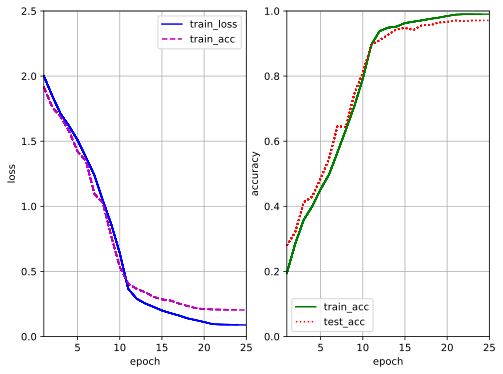

In [25]:
conv_arch = ((1,64),(1,128),(2,256),(2,512),(1,512))
#net = CNN()
net = VGG_1D(conv_arch)
ctx = d2l.try_gpu()
net.initialize(init.Xavier(),ctx = ctx)
loss = gloss.SoftmaxCrossEntropyLoss()
lr = 0.0001
trainer = gluon.Trainer(net.collect_params(), optimizer.Adam(learning_rate = lr))
train(net,train_iter,test_iter,25,ctx, 10, 0.1,True)

# 测试结果 (result of evalution)

In [26]:
num2emo = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fearful', 6:'disgust', 7:'surprised'}
def evaluate_emotions(Valid_iter, net, ctx):
    analys = DataFrame(0,index=num2emo.values(),columns=num2emo.values())
    n = 0
    all_acc=0;
    for X,y in Valid_iter:
        X = nd.array(X,dtype = 'float32').as_in_context(ctx)
        y = nd.array(y, dtype = 'float32').as_in_context(ctx)
        res = net(X).argmax(axis=1)
        all_acc += (res==y).sum().asscalar()
        res_list = []
        true_list = []
        n+=y.shape[0]
        for i in range(res.shape[0]):
            analys[num2emo[y[i].asscalar()]][num2emo[res[i].asscalar()]]+=1
            #ana_true[num2emo[y[i].asscalar()]]+=1
            #res_list.append(num2emo[res[i].asscalar()])
            #true_list.append(num2emo[y[i].asscalar()])
        #print('true emotion:     ',true_list,'\n\npredicted_emotion:',res_list)
        #print('\naccuracy:%.2d'%(accuracy.asscalar()*100),'%')
        #break;
    #for x in num2emo.values():
        #ana_true[x] = (1-ana_pred[x]/ana_true[x])*100
    print("accuracy of every emotion:")
    analys = analys.div(analys.sum(axis=1),axis=0)
    analys = analys.round(decimals = 4)
    for i in analys.index:
        analys[i] = analys[i].map(lambda x:format(x,".2%"))
    print(analys)
    print("sum:{:.2%}".format(all_acc/n))

valid_iter = gdata.DataLoader(test_data,32,shuffle = True,last_batch = 'keep')
evaluate_emotions(valid_iter,net,ctx)

accuracy of every emotion:
          neutral    calm   happy     sad    angry fearful disgust surprised
neutral    96.88%   0.00%   0.00%   3.12%    0.00%   0.00%   0.00%     0.00%
calm        1.30%  98.70%   0.00%   0.00%    0.00%   0.00%   0.00%     0.00%
happy       0.00%   1.75%  98.25%   0.00%    0.00%   0.00%   0.00%     0.00%
sad         0.00%   1.54%   3.08%  93.85%    0.00%   0.00%   1.54%     0.00%
angry       0.00%   0.00%   0.00%   0.00%  100.00%   0.00%   0.00%     0.00%
fearful     0.00%   0.00%   0.00%   0.00%    1.61%  96.77%   0.00%     1.61%
disgust     0.00%   0.00%   1.56%   0.00%    1.56%   0.00%  93.75%     3.12%
surprised   1.45%   0.00%   0.00%   0.00%    0.00%   0.00%   0.00%    98.55%
sum:97.08%


# VGG模型具体参数 (parameters of VGG)

In [6]:
conv_arch = ((1,64),(1,128),(2,256),(2,512),(1,512))
#net = CNN()
net = VGG_1D(conv_arch)
ctx = d2l.try_gpu()
net.initialize(init.Xavier(),ctx = ctx)
x = nd.zeros(shape = (64,1,199));
print(net.collect_params())
for i in net.params:
    x = i(x);
    print(x.shape)

vgg_1d3_ (
  Parameter conv21_weight (shape=(64, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv21_bias (shape=(64,), dtype=<class 'numpy.float32'>)
  Parameter conv22_weight (shape=(128, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv22_bias (shape=(128,), dtype=<class 'numpy.float32'>)
  Parameter conv23_weight (shape=(256, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv23_bias (shape=(256,), dtype=<class 'numpy.float32'>)
  Parameter conv24_weight (shape=(256, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv24_bias (shape=(256,), dtype=<class 'numpy.float32'>)
  Parameter conv25_weight (shape=(512, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv25_bias (shape=(512,), dtype=<class 'numpy.float32'>)
  Parameter conv26_weight (shape=(512, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv26_bias (shape=(512,), dtype=<class 'numpy.float32'>)
  Parameter conv27_weight (shape=(512, 0, 3), dtype=<class 'numpy.float32'>)
  Parameter conv27_bias (shape=(